In [ ]:
import numpy as np 
import torch.nn as nn
import torch
from torchvision import transforms as T
import os
from torchvision.models import efficientnet_b4, densenet121, maxvit_t, vit_b_16
from dataset import XrayDataset,Dataprep
from torchmetrics.classification import MultilabelAUROC, MultilabelAccuracy
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
classes = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']

BASE_PATH = './images/'
CSV_PATH = './Data_Entry_2017_v2020.csv'
TRAIN_LIST_PATH = './train_val_list.txt'
TEST_LIST_PATH = './test_list.txt'

In [6]:
_, df_val , df_test = Dataprep(classes).prep(BASE_PATH=BASE_PATH, CSV_PATH=CSV_PATH, 
                                                   TRAIN_LIST_PATH=TRAIN_LIST_PATH, TEST_LIST_PATH=TEST_LIST_PATH)
IMG_SIZE = 224
test_transform = T.Compose([T.Resize(IMG_SIZE),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
test_set = XrayDataset(df_test,transform=test_transform)
val_set = XrayDataset(df_val,transform=test_transform)

In [ ]:
model = densenet121()
model.classifier = nn.Linear(in_features=1024,out_features=len(classes),bias=True)
# model = efficientnet_b4()
# model.classifier[-1] = nn.Linear(in_features=1792,out_features=len(classes),bias=True)
# model = vit_b_16()
# model.heads = nn.Sequential(nn.Linear(768,len(classes),bias=True)),
# model = maxvit_t()
# model.classifier[-1] = nn.Linear(in_features=512,out_features=len(classes),bias=False)
model.load_state_dict(torch.load('./checkpoints/03_06_2024_12_45_39_DenseNet/03_06_2024_12_45_39_DenseNet_epoch_60.pth'))
model.eval()
model.to(device)



Prediction:  [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Predicted disease(s):  ['Pneumothorax' 'Emphysema']
Ground Truth:  [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Ground Truth disease(s):  ['Pneumothorax' 'Emphysema']


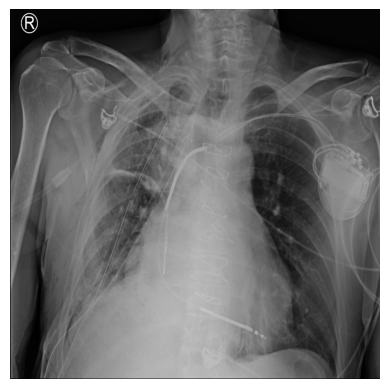

In [17]:
true_threshold = 0.75
model.eval()
img_index = 34
data = test_set[img_index]
inputs = data['image'].to(device).unsqueeze(0)
labels = data['label'].to(device)
labels = labels.to(torch.int)
with torch.no_grad():
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)
    # print(outputs.tolist())
    preds = (outputs >= true_threshold).int().squeeze()
    print('Prediction: ', preds.tolist())
    print('Predicted disease(s): ', np.array(classes)[preds.cpu().numpy() == 1])
    print('Ground Truth: ', labels.tolist())
    print('Ground Truth disease(s): ', np.array(classes)[labels.cpu().numpy() == 1])
IMG_PATH = df_test['Image Index'].iloc[img_index]
target_img = Image.open(BASE_PATH + IMG_PATH).convert('RGB')
plt.imshow(target_img)
plt.axis('off')
plt.show()

In [ ]:
count = 0
valuable_count = 0
number_images = len(test_set)
true_threshold = 0.7
model.eval()
auc_metric = MultilabelAUROC(num_labels=len(classes),average="macro", thresholds=None).to(device)
acc_metric = MultilabelAccuracy(num_labels=len(classes),threshold=true_threshold).to(device)

for img_index in range(number_images):
    # IMG_PATH = df_test['Image Index'].iloc[img_index]
    if img_index % 100 == 0:
        print(img_index)
    data = test_set[img_index]
    # data = val_set[img_index]
    inputs = data['image'].to(device).unsqueeze(0)
    labels = data['label'].to(device).unsqueeze(0)
    labels = labels.to(torch.int)

    with torch.no_grad():
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        # print(outputs.tolist())
        # print('Accuracy: ', acc_metric(outputs,labels))
        # print('Area Under Curve: ', auc_metric(outputs,labels).item())
        preds = (outputs >= true_threshold).int()
        if torch.all(preds == labels).item():
            count += 1
            if not torch.all(labels == 0).item():
                valuable_count += 1
                # print(img_index)
            # print('Image Index:', img_index)
            # print('prediction: ', preds.tolist())
            # print('Ground Truth: ', labels.tolist())

print('number of correct prediction:', count)     
print('number of valuable correct prediction:', valuable_count)     
print('number of correct prediction ratio:', count / number_images)     
# print('Accuracy: ', acc_metric(preds,labels))
# print('Area Under Curve: ', auc_metric(preds,labels).item())
    
